In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
import os
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import warnings
import statistics

data = pd.read_csv('../input/Monthly_data_cmo.csv')
data = data.dropna()
data.head()


,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04,Ahmadnagar,Maharashtra
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04,Ahmadnagar,Maharashtra
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04,Ahmadnagar,Maharashtra
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04,Ahmadnagar,Maharashtra


In [2]:
######################################Deleting the state column##################################
del data['state_name']

In [3]:
###############################################Data Visualization##########################################

In [4]:
def avg_modal(data):
###############Average model price with respect to each district and year################################
    district_to_year = data.groupby(['Year','district_name']).modal_price.mean().reset_index(name='Mean Modal Price')
##############Separating the data for each year
    district_to_year_2014 = district_to_year[district_to_year.Year == 2014]
    district_to_year_2015 = district_to_year[district_to_year.Year == 2015]
    district_to_year_2016 = district_to_year[district_to_year.Year == 2016]   
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(13)
    ax.plot(district_to_year_2014['district_name'],district_to_year_2014['Mean Modal Price'], label = '2014')
    ax.plot(district_to_year_2015['district_name'],district_to_year_2015['Mean Modal Price'], label = '2015')
    ax.plot(district_to_year_2016['district_name'],district_to_year_2016['Mean Modal Price'], label = '2016')
    ax.set(xlabel='District Name', ylabel='Mean Modal Price')
    fig.autofmt_xdate(rotation=90)
    ax.legend(loc = 'upper right')
    ax.set_title('Average Modal Price of all Commodities')

In [5]:
##########Function for filling in the missing district
def missing_district(ovr_data,data):
    fg = list(ovr_data.district_name.unique())
    temp = fg.copy();
    for i in range(len(fg)):
        if (sum(data.district_name == fg[i])) == 1:
            temp.remove(fg[i])
        if (sum(data.district_name == fg[i])) == 0:
            ye = []; di = []; val = [];
            ye.append(data.Year.iloc[1])
            di.append(fg[i])
            val.append(0)
            temp_df = pd.DataFrame(list(zip(ye, di, val)), columns =['Year','district_name','mean_modal_price']) 
            data = data.append(temp_df, ignore_index=True)
    return data
#################### Function for Grouping by commodity###################
###########################Function for plotting the modal price for each commodity separately#############################
def commodity_modal_price(data,commodity):
    import seaborn as sns
    district_to_quantity = data.groupby(['Commodity'])
    district_to_com = district_to_quantity.get_group(commodity)
    ######Grouping the wheat data by year and district for the respective average arrivals 
    district_to_com_arr= district_to_com.groupby(['Year','district_name']).modal_price.mean().reset_index(name='mean_modal_price')
    #######Dividing the data for year to do further analysis
    district_to_com_arr_2014 = district_to_com_arr[district_to_com_arr.Year == 2014]
    district_to_com_arr_2015 = district_to_com_arr[district_to_com_arr.Year == 2015]
    district_to_com_arr_2016 = district_to_com_arr[district_to_com_arr.Year == 2016]
    #####ADDING THE MISSING DISTRICT AND ASSIGNING THE VALUE AS ZERO
    district_to_com_arr_2014 = missing_district(data,district_to_com_arr_2014)
    district_to_com_arr_2015 = missing_district(data,district_to_com_arr_2015)
    district_to_com_arr_2016 = missing_district(data,district_to_com_arr_2016)
    ######Arranging the distict in alphabeticsl order
    district_to_com_arr_2014 = district_to_com_arr_2014.sort_values(by ='district_name' )
    district_to_com_arr_2015 = district_to_com_arr_2015.sort_values(by ='district_name' )
    district_to_com_arr_2016 = district_to_com_arr_2016.sort_values(by ='district_name' )
    ######plotting
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(13)
    ax.plot(district_to_com_arr_2014['district_name'],district_to_com_arr_2014['mean_modal_price'], label = '2014')
    ax.plot(district_to_com_arr_2015['district_name'],district_to_com_arr_2015['mean_modal_price'], label = '2015')
    ax.plot(district_to_com_arr_2016['district_name'],district_to_com_arr_2016['mean_modal_price'], label = '2016')
    ax.set(xlabel='District Name', ylabel='Modal Price')
    ax.set_title('Modal Price of Wheat(Husked)')
    fig.autofmt_xdate(rotation=90)
    ax.legend(loc = 'upper right')
    


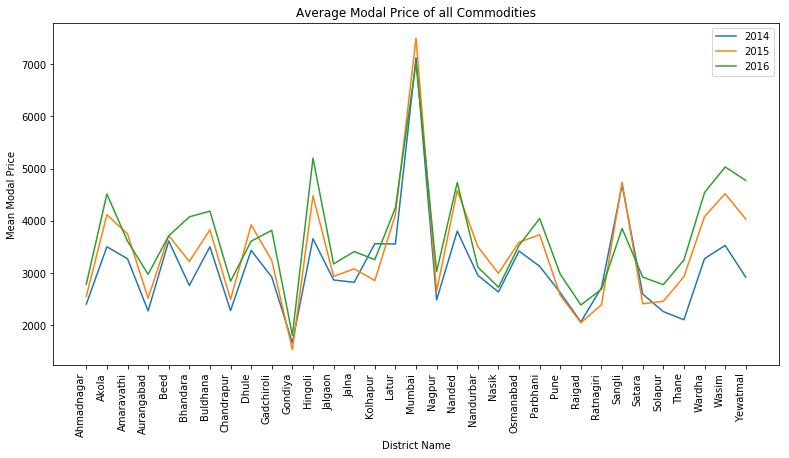

In [6]:
avg_modal(data)

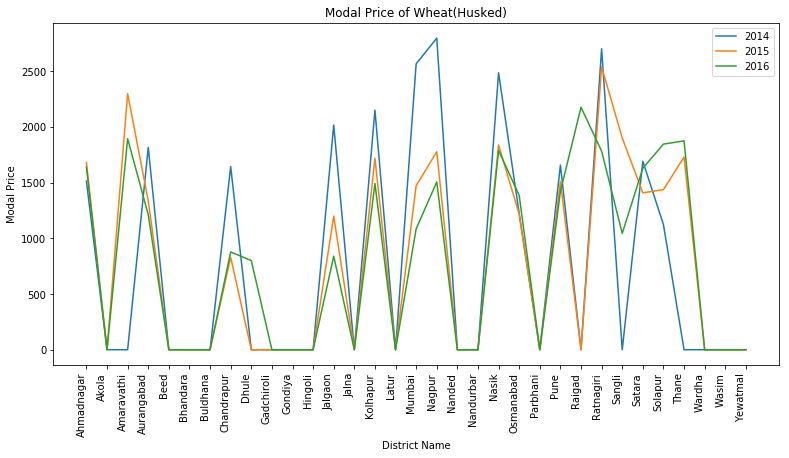

In [7]:
commodity_modal_price(data,'Carrot')

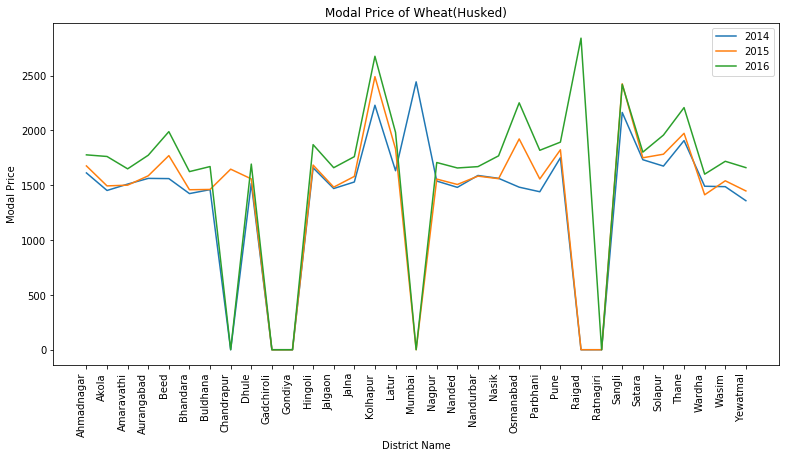

In [8]:
commodity_modal_price(data,'Wheat(Husked)')

In [9]:
######################################Changing the Categorial data into numerical data ###############
for i, t in data.loc[:, :].dtypes.iteritems():
    if t == object:
        data[i].fillna('unknown', inplace=True)
        data[i] = pd.factorize(data[i])[0]
data = data.drop(['date','Month','min_price','max_price'], axis=1)

In [10]:
########################Correlation Matrix##############################
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,APMC,Commodity,Year,arrivals_in_qtl,modal_price,district_name
APMC,1,0.0829351,-0.00922801,0.0184633,-0.0179122,0.996998
Commodity,0.0829351,1,0.148502,0.0197865,0.090905,0.0832037
Year,-0.00922801,0.148502,1,-0.00635788,0.0422844,-0.0107092
arrivals_in_qtl,0.0184633,0.0197865,-0.00635788,1,-0.0373472,0.0207775
modal_price,-0.0179122,0.090905,0.0422844,-0.0373472,1,-0.0130402
district_name,0.996998,0.0832037,-0.0107092,0.0207775,-0.0130402,1


In [11]:
##########################Splitting training and testing#######################
test = data[data.Year == 2016]
train = data[data.Year != 2016]
test_labels = test['modal_price']
train_labels = train['modal_price']
train_labels = train_labels/1000
test_labels = test_labels/1000
del train['modal_price']
del test['modal_price']

In [12]:
####################################################Linear Regressiion###########################
def linear(train, train_labels,test):
    reg = linear_model.BayesianRidge()
    reg.fit(train, train_labels)
    y_li = reg.predict(test)
    return y_li

In [13]:
#############################################LGBM#################################
def lgbm(train, train_labels,test):
    params={'learning_rate': 0.02,'objective':'regression','metric':'rmse','num_leaves': 31,'verbose': 1,'random_state':42,'bagging_fraction': 0.6,'feature_fraction': 0.6
           }
    folds = GroupKFold(n_splits=5)
    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(train, train_labels, eval_set=[(train, train_labels)], early_stopping_rounds=100, verbose=500)
    y_lgbm = reg.predict(test, num_iteration=reg.best_iteration_)
    return y_lgbm

In [14]:
##########################################K-NNR#######################################
def knn(train, train_labels,test):
    neigh = KNeighborsRegressor(n_neighbors=2)
    neigh.fit(train, train_labels) 
    y_knn = neigh.predict(test)
    return y_knn

In [15]:
y_knn = knn(train, train_labels,test)
y_lgbm = lgbm(train, train_labels,test)
y_li = linear(train, train_labels,test)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 1.39249
[1000]	training's rmse: 1.2715
[1500]	training's rmse: 1.21354
[2000]	training's rmse: 1.17102
[2500]	training's rmse: 1.138
[3000]	training's rmse: 1.10888
Did not meet early stopping. Best iteration is:
[3000]	training's rmse: 1.10888


In [16]:
#####################################Sampled Data for Time Series data##########################

In [17]:
###########################Parsing the date when reading the CSV file ############################
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data_par = pd.read_csv('../input/Monthly_data_cmo.csv', parse_dates=['date'], index_col='date',date_parser=dateparse)
###################Unique names for district and commodity######################
district = data_par.district_name.unique()
commodity = data_par.Commodity.unique()

In [18]:
#############################################Changing the sampling from monthly to 7 days ###############################
def upsampling(data_par,commodity):
    overall = pd.DataFrame()
    for j in commodity:
        temp1 = pd.DataFrame()
        temp1 = data_par[data_par.Commodity == j]
        temp1 = temp1[['modal_price']]
        temp1 = temp1.loc[:, ['modal_price']]
        sampling = temp1.modal_price.resample('7D', how = 'last')
        if temp1.shape[0] > 7:
            interpolation = sampling.interpolate(method='spline', order=2)
        else:
            interpolation = sampling.interpolate(method='spline', order=1)
        dr = pd.DataFrame()
        dr['Modal Price'] = interpolation
        com = j;
        dr['commodity'] = com
        overall = overall.append(dr)
    return overall

ARIMA

In [19]:
#########################################################Converting the data into stationary and implementing ARIMA in each commodity separately########################
warnings.filterwarnings("ignore")
def arima_prediction(overall):
    com = overall.commodity.unique()
    count = 1;
    arima_result = pd.DataFrame()
    forecasted_arima = pd.DataFrame()
    residual_arima = pd.DataFrame()
    for i in range(com.shape[0]):
        predicted_arima =[]
    #arima_temp = pd.DataFrame()
        ov_wheat = overall[overall.commodity == com[i]]
        ov_wheat_d = ov_wheat.drop(['commodity'], axis=1)
        ov_wheat_d_tr = ov_wheat_d.iloc[:-5]
        ov_wheat_d_te = ov_wheat_d.iloc[-5:]
        ov_wheat_d_l = np.log(ov_wheat_d_tr)
        ov_wheat_d_l_te = np.log(ov_wheat_d_te)
        ov_wheat_d_l_m = ov_wheat_d_l.copy()
        rolling_mean = ov_wheat_d_l.rolling(window=12).mean()
        ov_wheat_d_l_m = ov_wheat_d_l - ov_wheat_d_l.shift()
        ov_wheat_d_l_m = ov_wheat_d_l_m.replace([np.inf, -np.inf], np.nan)
        ov_wheat_d_l = ov_wheat_d_l.replace([np.inf, -np.inf], np.nan)
        ov_wheat_d_l_m= ov_wheat_d_l_m.dropna()
        ov_wheat_d_l= ov_wheat_d_l.dropna()
        if ov_wheat_d_l.shape[0] > 90:
            check = 0;
            count = count+1
            try:
                try:
                    try:
                        model = ARIMA(ov_wheat_d_l_m, order=(2,1,2))
                        results = model.fit(disp=-1)
                        residuals = pd.DataFrame(results.resid)
                        forc = results.predict(residuals.shape[0]+1,residuals.shape[0]+10)
                        forc_list = forc
                        check = 1
                    except ValueError:
                        model = ARIMA(ov_wheat_d_l_m, order=(1,1,1))
                        results = model.fit(disp=-1) 
                        residuals = pd.DataFrame(results.resid)
                        forc = results.predict(residuals.shape[0]+1,residuals.shape[0]+10)
                        forc_list = forc
                        check=1
                except:
                    model = ARIMA(ov_wheat_d_l_m, order=(5,1,1))
                    results = model.fit(disp=-1)
                    residuals = pd.DataFrame(results.resid)
                    forc = results.predict(residuals.shape[0]+1,residuals.shape[0]+10)
                    forc_list = forc
                    check=1
            except:
                #print(i)
                continue
            if check == 1:
                arima_temp = pd.DataFrame(results.fittedvalues)
            #########Retreiving the fitted value for each commodity###########################
                fitted_val = pd.Series(results.fittedvalues, copy=True)
                cumulative = fitted_val.cumsum()
                log_comp = pd.Series(ov_wheat_d_l['Modal Price'].iloc[0], index=ov_wheat_d_l.index)
                log_comp = log_comp.add(cumulative, fill_value=0)
                fitted_val_comp = np.exp(log_comp)
            #########Retreiving the forecasted value for each commodity#############################
                fitted_val1 = pd.Series(forc_list, copy=True)
                cumulative1 = fitted_val1.cumsum()
                log_comp1 = pd.Series(ov_wheat_d_l_te['Modal Price'].iloc[0], index=ov_wheat_d_l_te.index)
                cumulative1 = cumulative1.reindex(log_comp1.index)
                log_comp1 = log_comp1.add(cumulative1, fill_value=0)
                forecast_val_comp = np.exp(log_comp1)
            #############Outputting the fitted value for each commodity###################
                arima_temp['Original_predicted_value'] = pd.DataFrame(fitted_val_comp)
                arima_temp['actual_value'] = list(ov_wheat_d['Modal Price'].iloc[:arima_temp.shape[0]])
                arima_temp['original_actual_value'] = list(ov_wheat_d_l_m['Modal Price'].iloc[:arima_temp.shape[0]])
                arima_temp['Commodity'] = [com[i]]*(arima_temp.shape[0])
                arima_result = arima_result.append(arima_temp)
            ############Outputting theForecasted data for next 10 weeks for each commodity################
                forc_temp = pd.DataFrame(forecast_val_comp)
                forc_temp['Commodity'] = [com[i]]*(forc_temp.shape[0])
                forc_temp['Actual_value'] = ov_wheat_d_te
                forecasted_arima = forecasted_arima.append(forc_temp)
            ###########Outputting the Residual data for each commodity#############
                residuals['Commodity'] = [com[i]]*(residuals.shape[0])
                residual_arima = residual_arima.append(residuals)
            
    arima_result.columns  = ['predicted_value','original_predicted_value','original_actual_value','actual_value','Commodity']
    residual_arima.columns  = ['residuals','Commodity']
    forecasted_arima.columns  = ['Forecasted_value','Commodity','Actual_value']
    return arima_result,residual_arima,forecasted_arima

In [20]:
#########################################function to plot the stationary datapoints#######################
def arima_plot(data,commodity):
    data_com = data[data.Commodity == commodity]
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(9)
    ax.plot(data_com.predicted_value,label = 'Predicted value')
    ax.plot(data_com.actual_value,label = 'Actual value')
    ax.set(xlabel='Date', ylabel='Modal Price')
    ax.set_title('Actual vs Predicted values for ' + str(commodity))
    fig.autofmt_xdate(rotation=90)
    ax.legend(loc = 'upper left')
#########################################function to plot the Actual datapoints#######################    
def arima_org_plot(data,commodity):
    data_com = data[data.Commodity == commodity]
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(9)
    #ax.plot(data_com.original_predicted_value,label = 'Predicted value')
    ax.plot(data_com.original_actual_value,label = 'Actual value')
    ax.set_title('Actual data points for '+ str(commodity))
    ax.set(xlabel='Date', ylabel='Modal Price')
    fig.autofmt_xdate(rotation=90)
    ax.legend(loc = 'upper left')
    
    #############Error Residuals###########
def arima_residue_plot(data,commodity):
    data_com = data[data.Commodity == commodity]
    data_com.plot(title="Residuals")
    data_com.plot(kind='kde', title='Density')
    plt.show()
    ############Forecasted values##########
def forecasted(data,commodity):
    data_com = data[data.Commodity == commodity]
    plt.plot(data_com['Forecasted_value'],label = 'Forecasted value')
    plt.plot(data_com['Actual_value'],label = 'Actual value')
    plt.legend()

In [21]:
overall = upsampling(data_par,commodity)
arima_result,residual_arima,forecasted_arima = arima_prediction(overall)

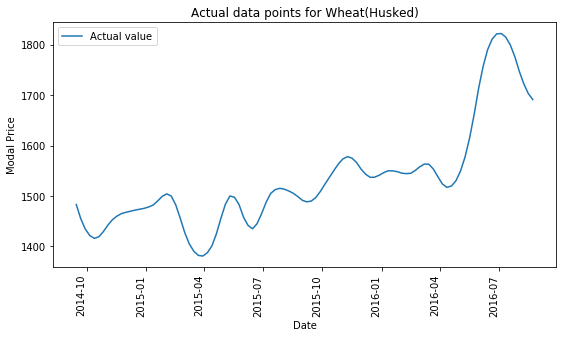

In [22]:
arima_org_plot(arima_result,'Wheat(Husked)')

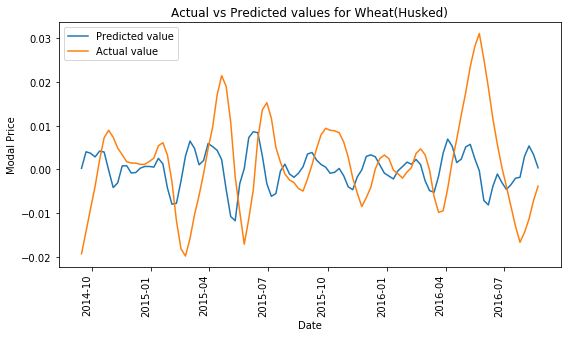

In [23]:
arima_plot(arima_result,'Wheat(Husked)')

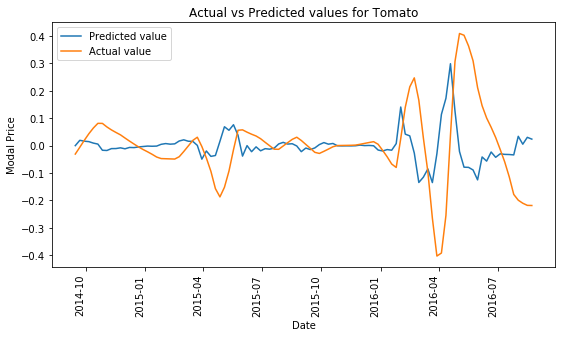

In [24]:
arima_plot(arima_result,'Tomato')

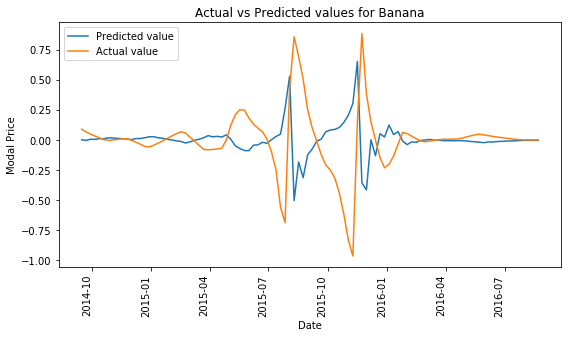

In [25]:
arima_plot(arima_result,'Banana')

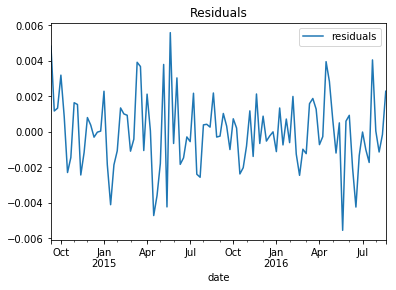

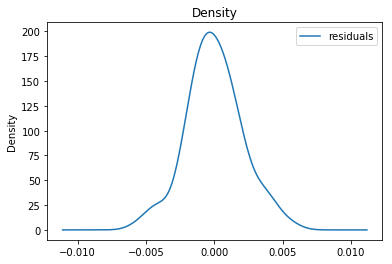

In [26]:
arima_residue_plot(residual_arima,'Wheat(Husked)')

In [27]:
###################################################################Calculating the error value for all the four models################################################

def err(act,pred_knn,pred_lgbm,pred_li,residual_arima):
    vs_knn = explained_variance_score(pred_knn,act)
    mae_knn = mean_absolute_error(pred_knn,act)
    mse_knn =np.sqrt(mean_squared_error(pred_knn,act))
    rmese_knn = np.sqrt(statistics.median((pred_knn - act)**2))
    meae_knn = median_absolute_error(pred_knn,act)
    r2_knn = r2_score(pred_knn,act)
    
    vs_lgbm = explained_variance_score(pred_lgbm,act)
    mae_lgbm = mean_absolute_error(pred_lgbm,act)
    mse_lgbm =np.sqrt(mean_squared_error(pred_lgbm,act))
    rmese_lgbm = np.sqrt(statistics.median((pred_lgbm - act)**2))
    meae_lgbm = median_absolute_error(pred_lgbm,act)
    r2_lgbm = r2_score(pred_lgbm,act)
    
    vs_li = explained_variance_score(pred_li,act)
    mae_li = mean_absolute_error(pred_li,act)
    mse_li =np.sqrt(mean_squared_error(pred_li,act))
    rmese_li = np.sqrt(statistics.median((pred_li- act)**2))
    meae_li = median_absolute_error(pred_li,act)
    r2_li = r2_score(pred_li,act)
    
    rmse_arima = np.exp(np.sqrt((residual_arima['residuals']**2).mean()))
    mae_arima = np.exp(((np.abs(residual_arima['residuals']).mean())))
    meae_arima = np.exp(((np.abs(residual_arima['residuals']).median())))
    rmese_arima = np.exp(np.sqrt(((residual_arima['residuals']**2).median())))
    ##########################BAR plot of error values for four models###########################
    #vs = (vs_knn, vs_lgbm, vs_li,2)
    #mae = (mae_knn,mae_lgbm, mae_li,mae_arima)
    #mse = (np.sqrt(mse_knn),np.sqrt(mse_lgbm), np.sqrt(mse_li),rmse_arima)
    #meae = (meae_knn,meae_lgbm, meae_li,meae_arima)
    #r2_scr = (r2_knn,r2_lgbm, r2_li)
    
    knn = (mse_knn,mae_knn,meae_knn,rmese_knn)
    
    lgbm = (mse_lgbm,mae_lgbm,meae_lgbm,rmese_lgbm)
    li = (mse_li,mae_li,meae_li,rmese_li)
    ar = (rmse_arima,mae_arima,meae_arima,rmese_arima)
    fig, ax = plt.subplots()

    ind = np.arange(4)
    width = 0.15
    p1 = ax.bar(ind,li, width, bottom=0)
    fig.set_figheight(5)
    fig.set_figwidth(9)
    p2 = ax.bar(ind + width, knn, width, bottom=0)
    p3 = ax.bar(ind + width+ width, lgbm, width, bottom=0)
    p4 = ax.bar(ind + width+ width +width, ar, width, bottom=0)
    ax.set_title('Error Values for Forecast models')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('RMSE', 'MAE','MEAE','RMESE'))

    ax.legend((p1[0], p2[0], p3[0],p4[0]), ('Linear regression','KNN','LGBM','ARIMA'))

    plt.show()
#####################################Actual vs Predicted values for the first three models#########################
    x = list(range(act.shape[0]))
    plt.figure(figsize=(13, 7))
    #y = act - pred_lgbm
    #plt.plot(x[100:200],y[100:200],label = 'Actual')
    plt.plot(x[100:200],act[100:200],label = 'Actual')
    plt.plot(x[100:200],pred_knn[100:200],label = 'KNN')
    plt.plot(x[100:200],pred_lgbm[100:200],label = 'LGBM')
    plt.plot(x[100:200],pred_li[100:200],label = 'Linear')
    plt.legend(loc = 'upper right')
    plt.title('Actual vs Predicted value for all three models')
    plt.xlabel('x --->')
    plt.ylabel('Modal Price --->')
    return knn,lgbm,li,ar

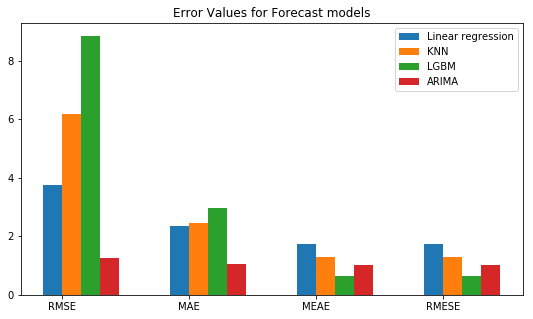

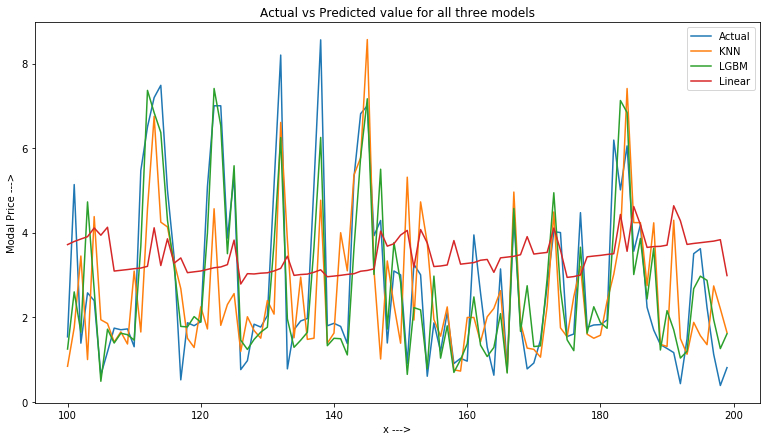

In [28]:
knn,lgbm,linear,arima_err = err(test_labels,y_knn,y_lgbm,y_li,residual_arima)